# 3D Neural Style Transfer

This is the Jupyter Notebook for 3D neural style transfer. The goal is to transfer style from a 2D style image onto a 3D mesh, either reshaping the mesh or texturing the mesh. The mesh has no UV map or texture map at the beginning.

At some specific iterations during optimization, rendering is plotted and stylized mesh is saved as .obj file in the directory ***runtime_objs***. These specific iterations are defined with the variable ***plot_period***.

This notebook can be directly run on Google Colab without additional effort. For acceleration it is helpful to use a GPU runtime.

## Step 0: imports

In [1]:
import sys
import torch

# install PyTorch3D
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install -q pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.utils import ico_sphere, torus
from pytorch3d.renderer import TexturesVertex

# install KeOps kernels
!pip install -q pykeops==1.4.1 # > install.log

# install pytorch version of np.Interp, which is used for histogram loss
!pip install -q git+https://github.com/aliutkus/torchinterp1d.git

# Please run the following two lines DEPENDENTLY! (depends on whether the notebook is run locally or on Colab)
!git clone https://github.com/wmd0701/MA.git NST
%cd NST
!mkdir runtime_objs # directory that stores obj files generated during optimization

# import self-defined functions
from utils.data_loader import image_loader, image_unloader
from utils.pipeline import pipeline_3D_NST
from utils.mesh_preprocess import plot_pointcloud
from utils.plot import plot_loss
from utils.renderer import grid_plot, single_plot

# better plot
%pylab inline

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     |████████████████████████████████| 44.7 MB 115 kB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 65.0 MB/s 
     |████████████████████████████████| 319 kB 29.0 MB/s 
Cloning into 'NST'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 229 (delta 110), reused 161 (delta 46), pack-reused 0
Receiving objects: 100% (229/229), 34.69 MiB | 25.14 MiB/s, done.
Resolving deltas: 100% (110/110), done.
/content/NST
Populating the interactive namespace from numpy and matplotlib


## Step 1: load images

torch.Size([1, 3, 256, 384])


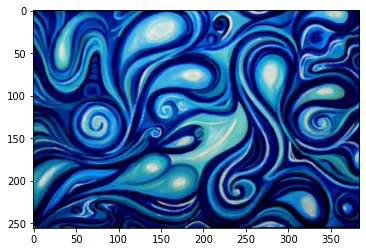

In [2]:
# style_img = image_loader("./image_style/starry_night.jpg", imsize=256, tiling=1, freq_lower = None, freq_upper = None)
# style_img = image_loader("./image_style/patterned_leaves.jpg", imsize=256, tiling=1, freq_lower = None, freq_upper = None)
style_img = image_loader("./image_style/blue_swirls.jpg", imsize = 256, tiling = 1, freq_lower = None, freq_upper = None)

print(style_img.shape)
imshow(image_unloader(style_img));show()

## Step 2: load mesh

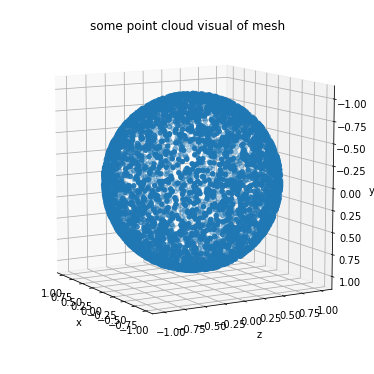

In [3]:
# generate  mesh using PyTorch3D API, or just load it from repository
# org_mesh = ico_sphere(7, device)
# src_mesh = torus(r = 4, R = 4, sides = 350, rings = 400, device = device)
# org_mesh = load_objs_as_meshes(["meshes/igea.obj"], device=device)
# org_mesh = load_objs_as_meshes(["meshes/cube_80samples.obj"], device=device)
src_mesh = load_objs_as_meshes(["meshes/ico_sphere_level7.obj"], device=device)

# have some visualization on point cloud, not necessary
plot_pointcloud(src_mesh, title = "some point cloud visual of mesh")

## Step 3: run neural style transfer pipeline

### example 1: reshaping

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


no cameras are given, and sampling_cameras is False
number of cameras: 1


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

  0%|          | 0/500 [00:00<?, ?it/s]

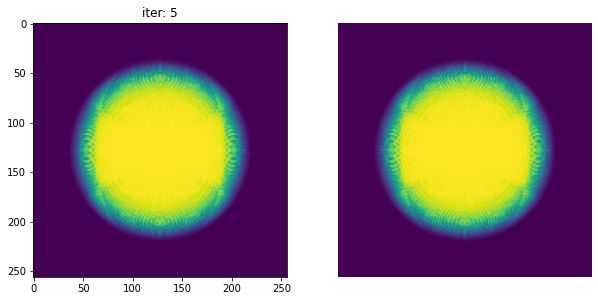

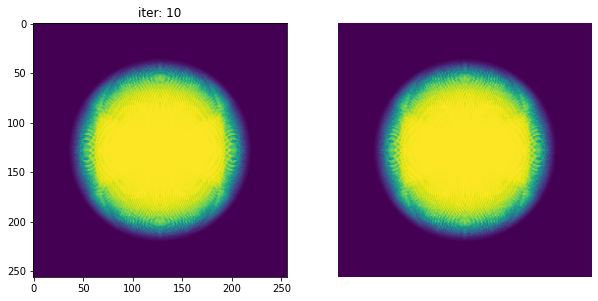

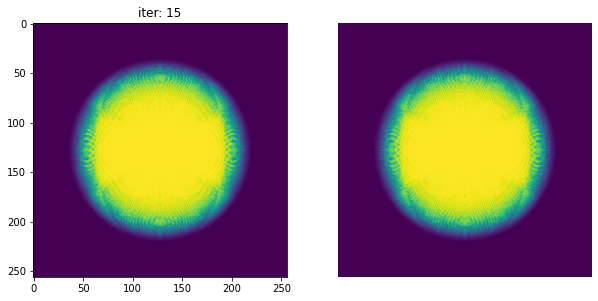

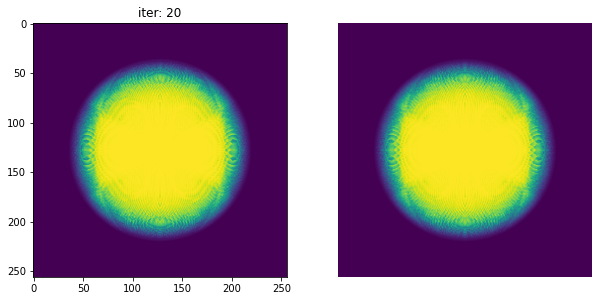

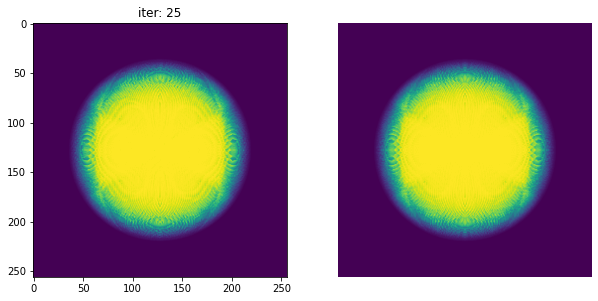

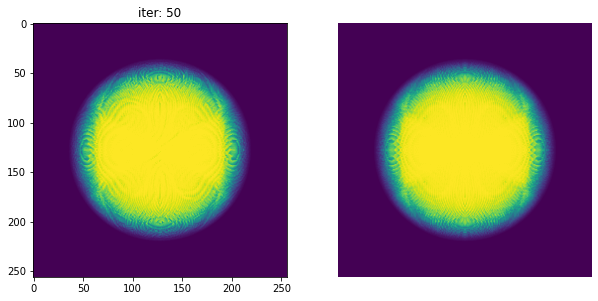

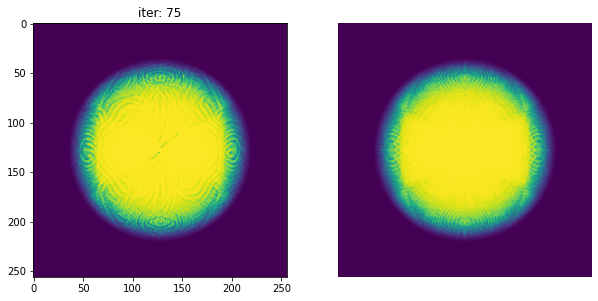

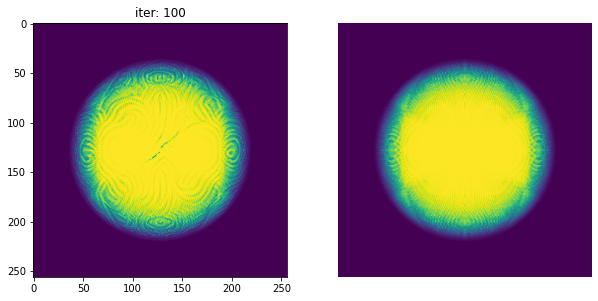

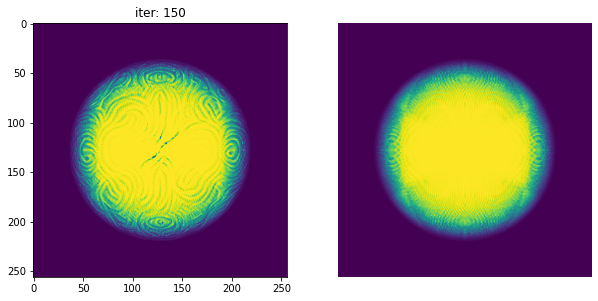

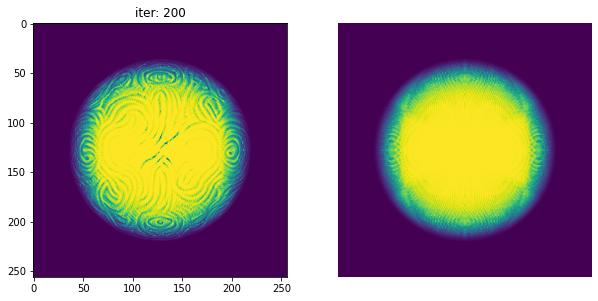

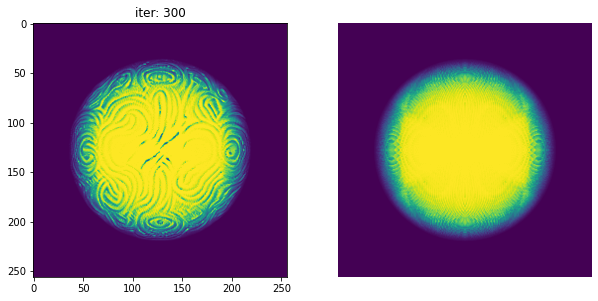

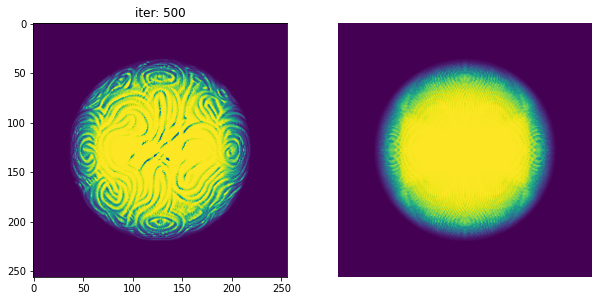

In [4]:
# reload mesh
org_mesh = src_mesh.clone()

# style layers and weights
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
style_weights = [1e6/n**2 for n in [64,128,256,512]]

# image size of rendering
rendering_size = 256

# style loss types and corresponding weights
style_loss_types = {'gram': 1,
                    #'bnst':1,
                    #'morest':1,
                    #'histo':1,
                    #'poly':1,
                    #'linear':1,
                    #'rbf':1e2
                    }

# camera settings
# by default, only using a single fixed camera, thus only small part of mesh is stylized
# you can use more cameras by either setting sampling_cameras to True, or adding more camera positions in elevs and azims
# when using more cameras, increase n_iterations respectively
sampling_cameras = False
elevs = torch.tensor([0])
azims = torch.tensor([0])                  
perspective_camera = True
camera_dist = 2.7
faces_per_pixel = 50
n_views_per_iter = 4

# number of optimization iterations and learning rate
n_iterations = 500
optim_type, learning_rate = 'reshaping', 1e-5
# optim_type, learning_rate = 'texturing', 1e-2

# plot rendering and save mesh at specific iterations
plot_period = [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500, 2000]

# masking
masking = False
mask_pooling = 'avg'

# max or avg pooling
model_pooling = 'max'

# whether compel color in range [0, 1], meaningless in case of reshaping
clamping = False

# whether reshaping with colorful renderings or silhouette renderings
reshaping_rgb = False

# pipeline
what_to_optimize, cameras, loss_history, rendering_at_iter = pipeline_3D_NST( org_mesh,
                                                                              style_img,
                                                                              optim_type = optim_type,
                                                                              optim_init = None,
                                                                              rendering_size = rendering_size,
                                                                              style_layers = style_layers,
                                                                              style_weights = style_weights,
                                                                              n_views_per_iter = n_views_per_iter, 
                                                                              cameras = None,
                                                                              sampling_cameras = sampling_cameras,
                                                                              elevs = elevs,
                                                                              azims = azims,   
                                                                              perspective_camera = perspective_camera,
                                                                              camera_dist = camera_dist,
                                                                              faces_per_pixel = faces_per_pixel,
                                                                              n_iterations = n_iterations, 
                                                                              learning_rate = learning_rate,
                                                                              plot_period = plot_period,
                                                                              style_loss_types = style_loss_types,
                                                                              masking = masking,
                                                                              model_pooling = model_pooling,
                                                                              mask_pooling = mask_pooling,
                                                                              clamping = clamping,
                                                                              reshaping_rgb = reshaping_rgb
                                                                              )

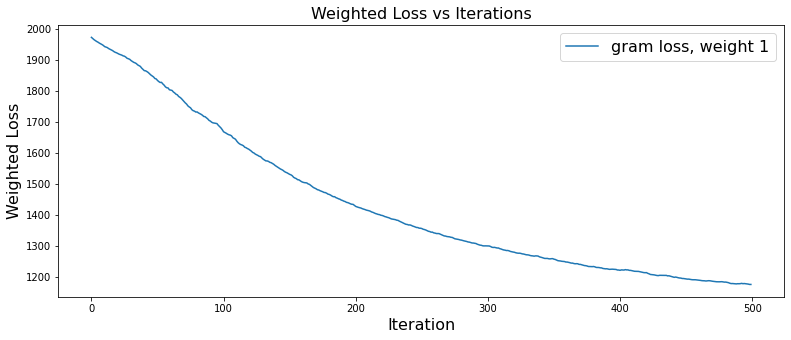

In [5]:
# plot loss
plot_loss(loss_history, loss_name = None, start = 0, end = n_iterations)

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


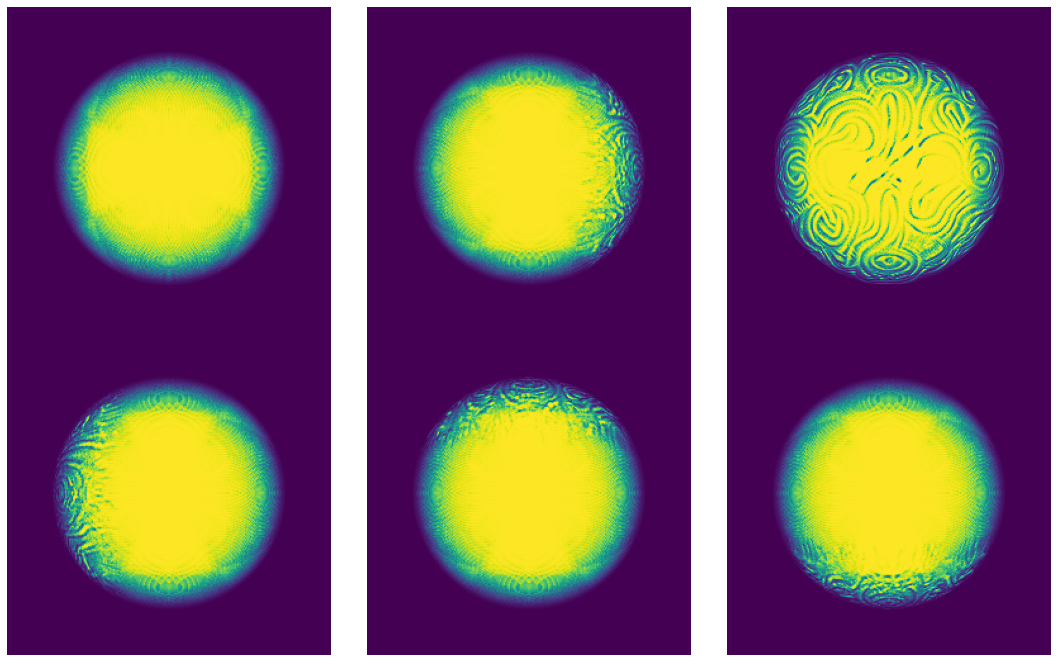

In [6]:
# more views of mesh
plot_mesh = src_mesh.clone()
plot_mesh.offset_verts_(what_to_optimize)
grid_plot(plot_mesh, sil_shader = True, rgb = False, rendering_size = 256)

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


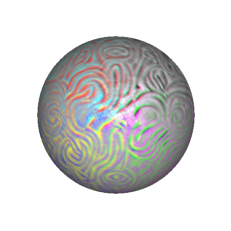

In [7]:
# what if taking per-vertex position offset as per-vertex color?
what_to_optimize_normalized = what_to_optimize - what_to_optimize.min()
what_to_optimize_normalized = what_to_optimize_normalized / what_to_optimize_normalized.max()
plot_mesh = src_mesh.clone()
plot_mesh.textures = TexturesVertex(verts_features = what_to_optimize_normalized.unsqueeze(0))
single_plot(plot_mesh, sil_shader = False, rgb=True)

### example 2: texturing

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


no cameras are given, and sampling_cameras is False
number of cameras: 1


  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

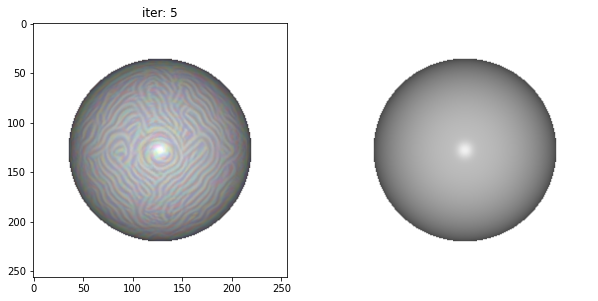

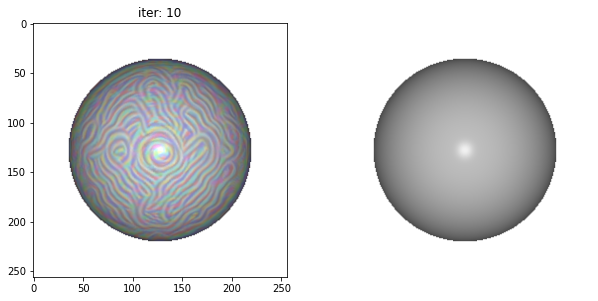

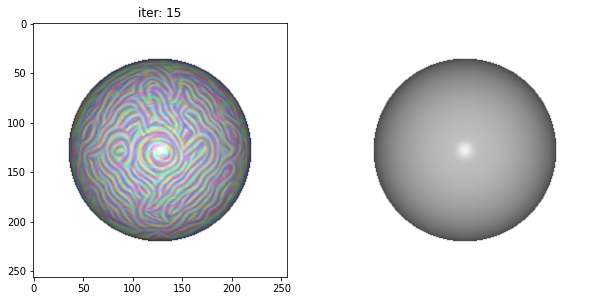

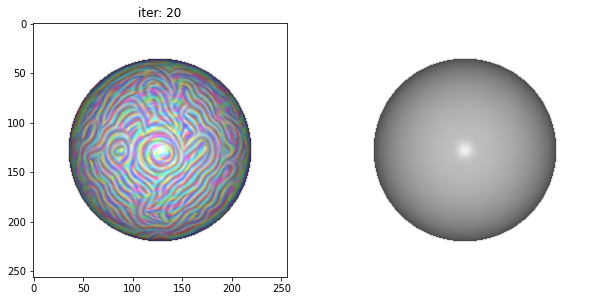

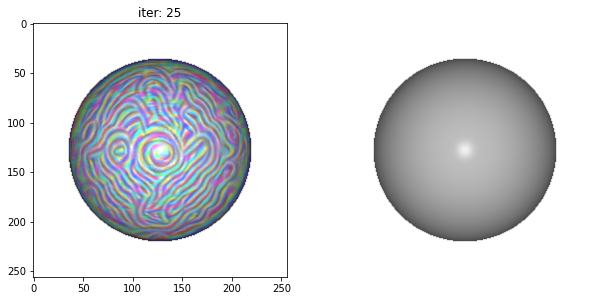

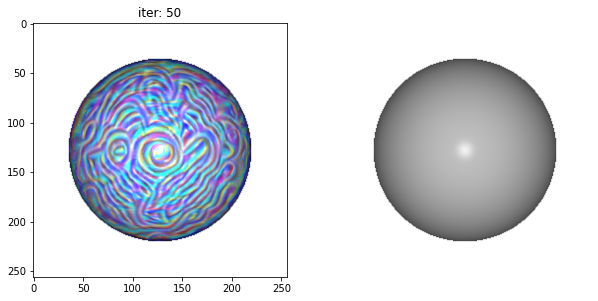

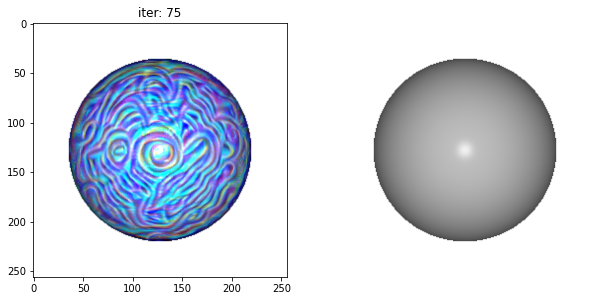

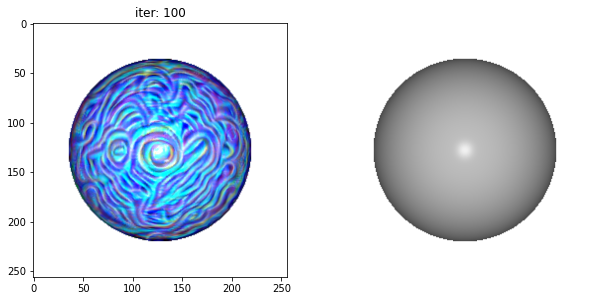

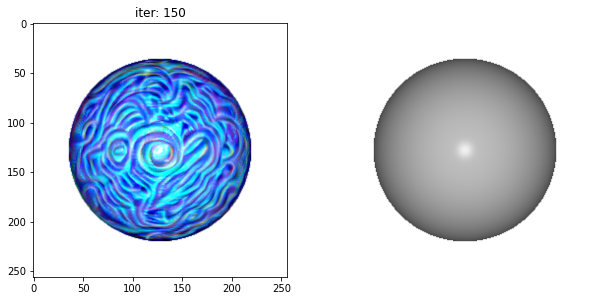

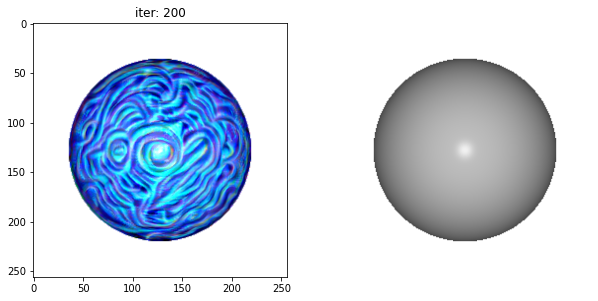

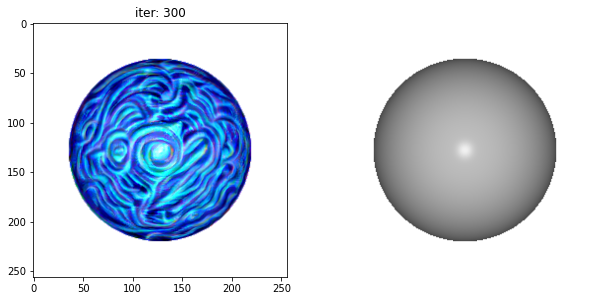

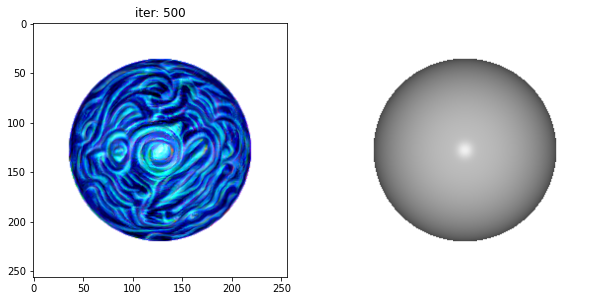

In [8]:
# reload mesh
org_mesh = src_mesh.clone()

# style layers and weights
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
style_weights = [1e6/n**2 for n in [64,128,256,512]]

# image size of rendering
rendering_size = 256

# style loss types and corresponding weights
style_loss_types = {#'gram': 1,
                    'bnst':1,
                    #'morest':1,
                    #'histo':1,
                    #'poly':1,
                    #'linear':1,
                    #'rbf':1e2
                    }

# camera settings
# by default, only using a single fixed camera, thus only small part of mesh is stylized
# you can use more cameras by either setting sampling_cameras to True, or adding more camera positions in elevs and azims
# when using more cameras, increase n_iterations respectively
sampling_cameras = False
elevs = torch.tensor([0])
azims = torch.tensor([0])                  
perspective_camera = True
camera_dist = 2.7
faces_per_pixel = 50
n_views_per_iter = 4

# number of optimization iterations and learning rate
n_iterations = 500
# optim_type, learning_rate = 'reshaping', 1e-5
optim_type, learning_rate = 'texturing', 1e-2

# plot rendering and save mesh at specific iterations
plot_period = [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500, 2000]

# masking
masking = False
mask_pooling = 'avg'

# max or avg pooling
model_pooling = 'max'

# whether compel color in range [0, 1]
clamping = False

# whether reshaping with colorful renderings or silhouette rendering, meaningless in case of texturing
reshaping_rgb = False

# pipeline
what_to_optimize, cameras, loss_history, rendering_at_iter = pipeline_3D_NST( org_mesh,
                                                                              style_img,
                                                                              optim_type = optim_type,
                                                                              optim_init = None,
                                                                              rendering_size = rendering_size,
                                                                              style_layers = style_layers,
                                                                              style_weights = style_weights,
                                                                              n_views_per_iter = n_views_per_iter, 
                                                                              cameras = None,
                                                                              sampling_cameras = sampling_cameras,
                                                                              elevs = elevs,
                                                                              azims = azims,   
                                                                              perspective_camera = perspective_camera,
                                                                              camera_dist = camera_dist,
                                                                              faces_per_pixel = faces_per_pixel,
                                                                              n_iterations = n_iterations, 
                                                                              learning_rate = learning_rate,
                                                                              plot_period = plot_period,
                                                                              style_loss_types = style_loss_types,
                                                                              masking = masking,
                                                                              model_pooling = model_pooling,
                                                                              mask_pooling = mask_pooling,
                                                                              clamping = clamping,
                                                                              reshaping_rgb = reshaping_rgb
                                                                              )

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow

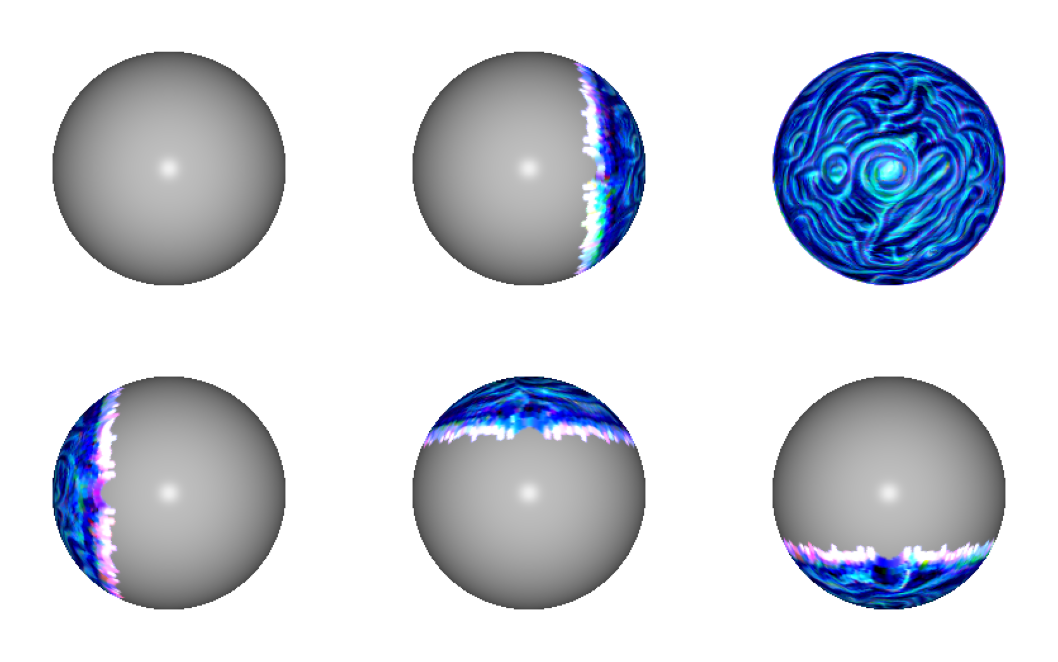

In [9]:
# more views of mesh
plot_mesh = src_mesh.clone()
plot_mesh.textures = TexturesVertex(verts_features = what_to_optimize.detach())
grid_plot(plot_mesh, sil_shader = False, rgb = True, rendering_size = 256)

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


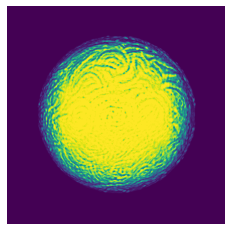

In [10]:
# what if taking per-vertex color as per-vertex position offset?
plot_mesh = src_mesh.clone()
plot_mesh.offset_verts_(what_to_optimize[0]/1e2)
single_plot(plot_mesh, sil_shader = True, rgb=False)

### example 3: reshaping using colorful renderings

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


no cameras are given, and sampling_cameras is False
number of cameras: 1


  0%|          | 0/500 [00:00<?, ?it/s]

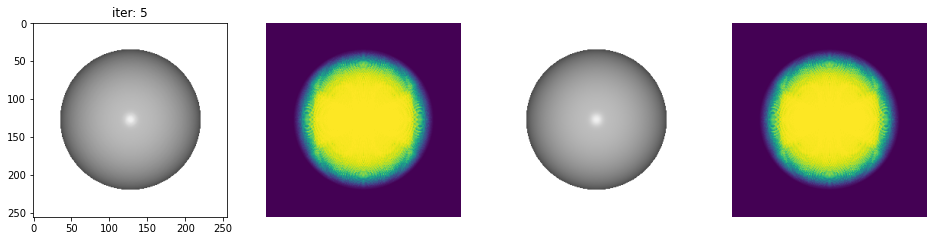

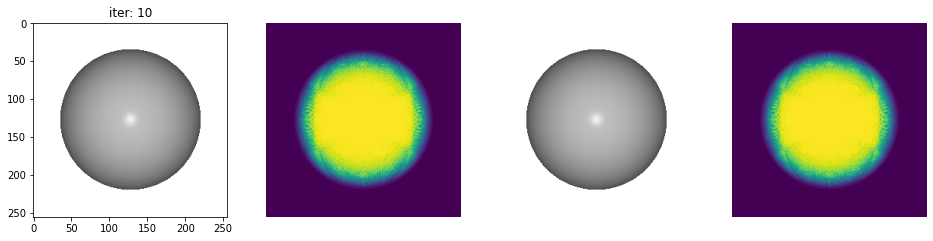

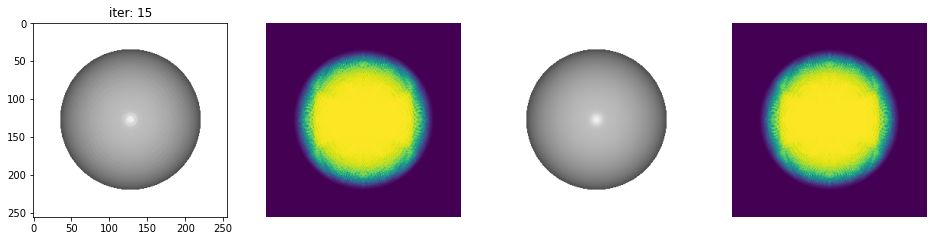

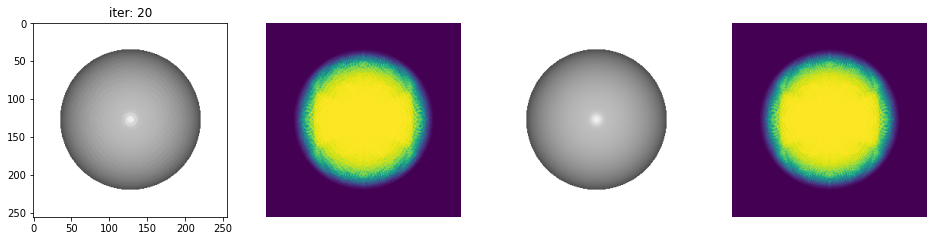

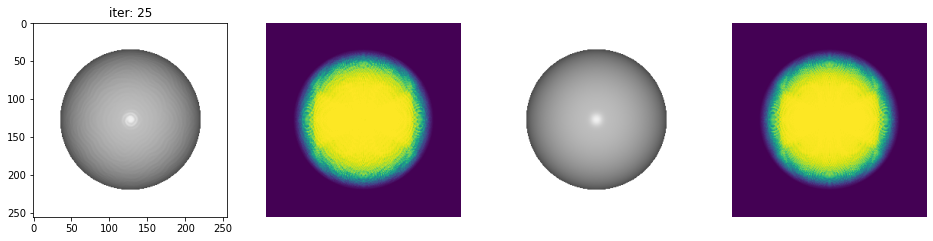

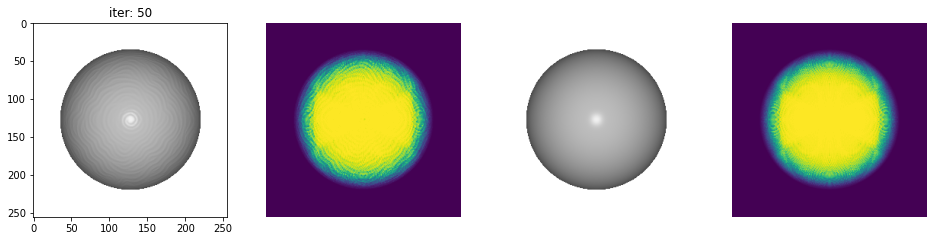

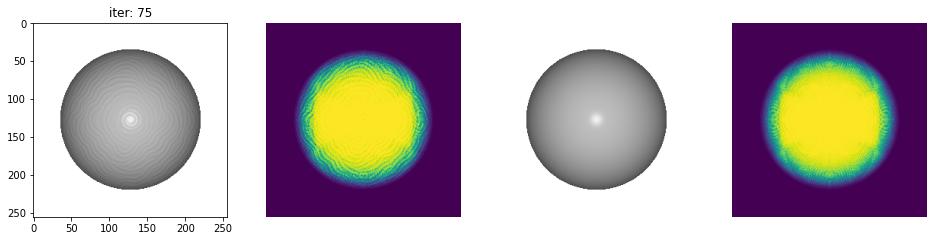

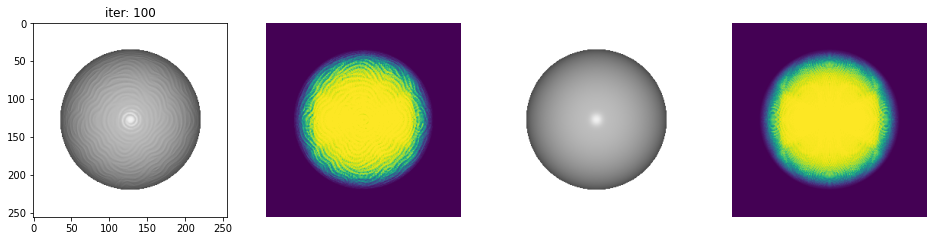

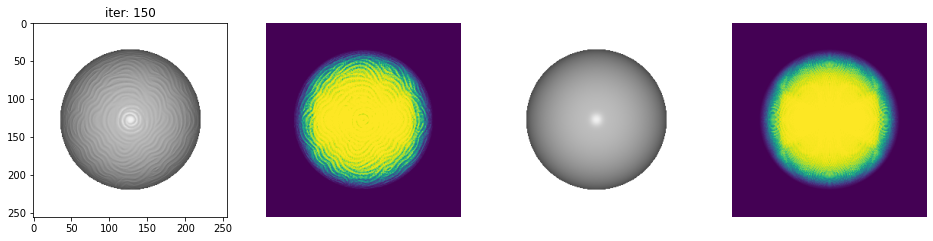

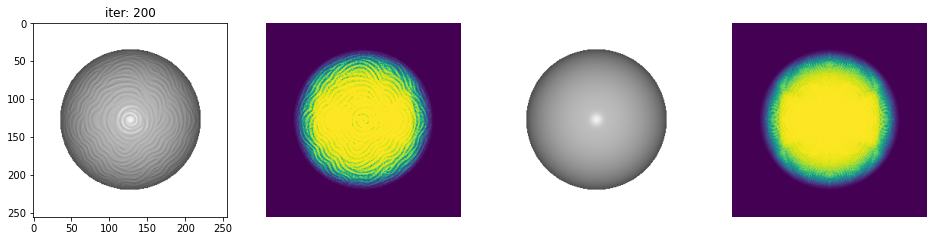

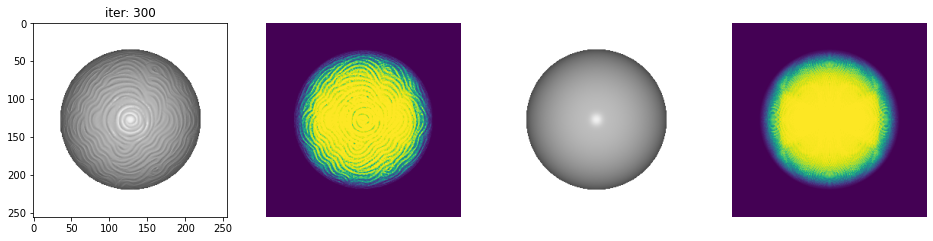

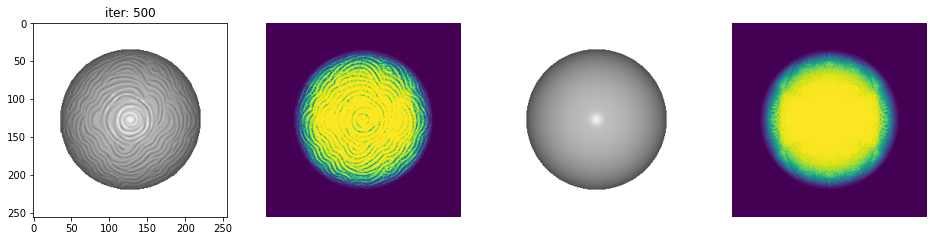

In [11]:
# reload image and mesh
org_mesh = src_mesh.clone()

# style layers and weights
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
style_weights = [1e6/n**2 for n in [64,128,256,512]]

# image size of rendering
rendering_size = 256

# style loss types and corresponding weights
style_loss_types = {'gram': 1,
                    #'bnst':1,
                    #'morest':1,
                    #'histo':1,
                    #'poly':1,
                    #'linear':1,
                    #'rbf':1e2
                    }

# camera settings
# by default, only using a single fixed camera, thus only small part of mesh is stylized
# you can use more cameras by either setting sampling_cameras to True, or adding more camera positions in elevs and azims
# when using more cameras, increase n_iterations respectively
sampling_cameras = False
elevs = torch.tensor([0])
azims = torch.tensor([0])                  
perspective_camera = True
camera_dist = 2.7
faces_per_pixel = 50
n_views_per_iter = 4

# save some data at special iterations
n_iterations = 500
optim_type, learning_rate = 'reshaping', 1e-5
# optim_type, learning_rate = 'texturing', 1e-2
plot_period = [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500, 2000]

# masking
masking = False
mask_pooling = 'avg'

# max or avg pooling
model_pooling = 'max'

# whether compel color in range [0, 1], meaningless in case of reshaping
clamping = False

# whether reshaping with colorful renderings
reshaping_rgb = True
                                                                                       
what_to_optimize, cameras, loss_history, rendering_at_iter = pipeline_3D_NST( org_mesh,
                                                                              style_img,
                                                                              optim_type = optim_type,
                                                                              optim_init = None,
                                                                              rendering_size = rendering_size,
                                                                              style_layers = style_layers,
                                                                              style_weights = style_weights,
                                                                              n_views_per_iter = n_views_per_iter, 
                                                                              cameras = None,
                                                                              sampling_cameras = sampling_cameras,
                                                                              elevs = elevs,
                                                                              azims = azims,   
                                                                              perspective_camera = perspective_camera,
                                                                              camera_dist = camera_dist,
                                                                              faces_per_pixel = faces_per_pixel,
                                                                              n_iterations = n_iterations, 
                                                                              learning_rate = learning_rate,
                                                                              plot_period = plot_period,
                                                                              style_loss_types = style_loss_types,
                                                                              masking = masking,
                                                                              model_pooling = model_pooling,
                                                                              mask_pooling = mask_pooling,
                                                                              clamping = clamping,
                                                                              reshaping_rgb = reshaping_rgb
                                                                              )

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


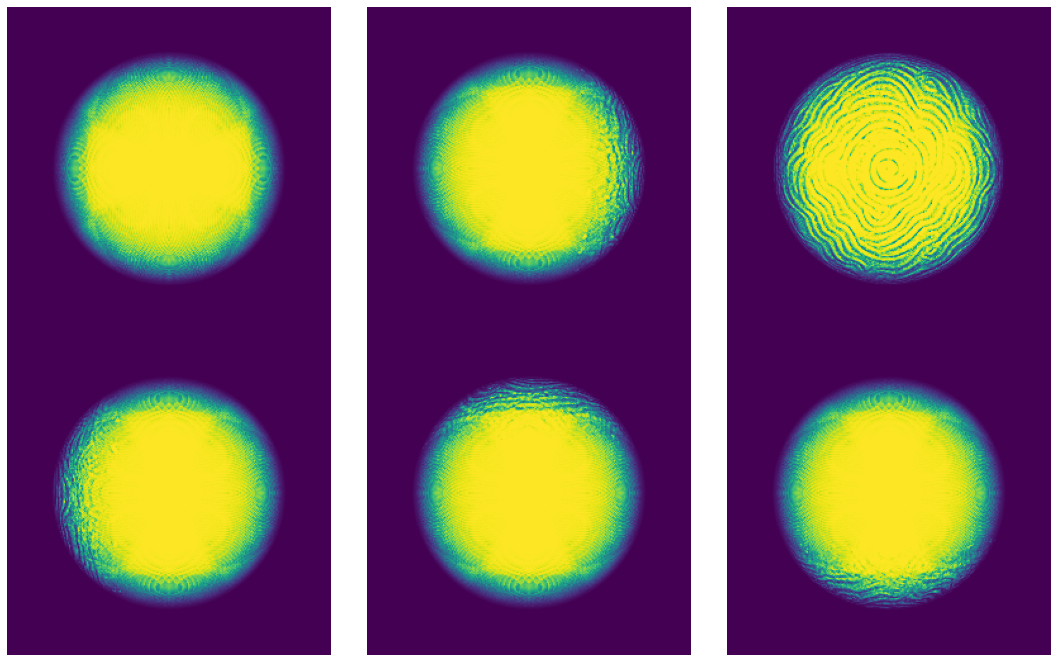

In [12]:
# more views of mesh, silhouette
plot_mesh = src_mesh.clone()
plot_mesh.offset_verts_(what_to_optimize)
grid_plot(plot_mesh, sil_shader = True, rgb = False, rendering_size = 256)

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


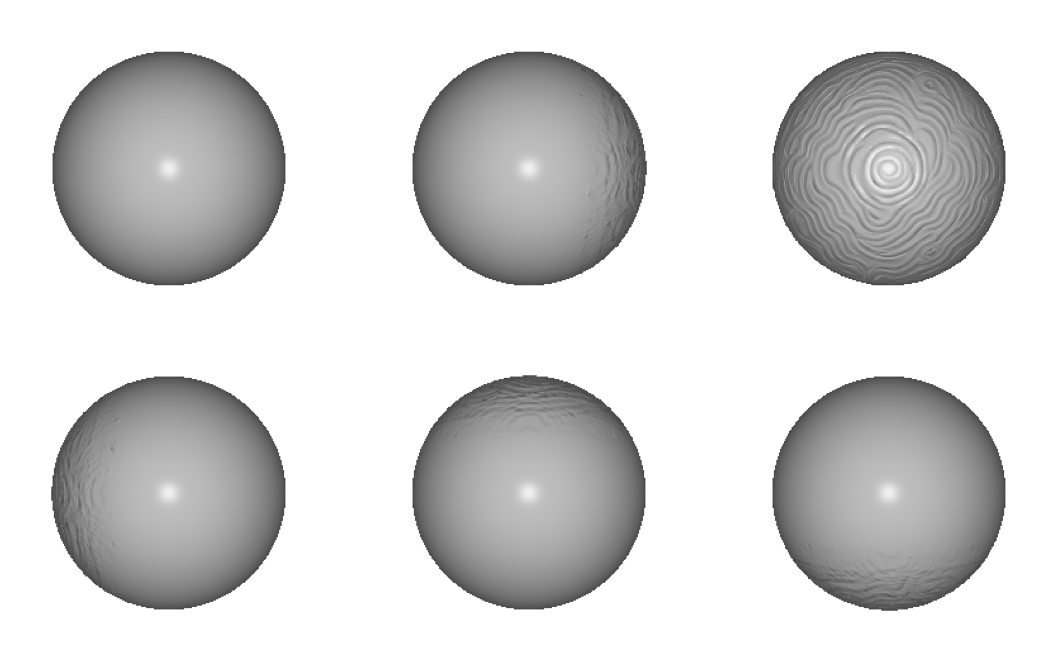

In [14]:
# more views of mesh, colorful
plot_mesh = src_mesh.clone()
plot_mesh.offset_verts_(what_to_optimize)
verts_shape = plot_mesh.verts_packed().shape
default_color = torch.full([1, verts_shape[0], 3], 0.5, device=device)
plot_mesh.textures = TexturesVertex(verts_features = default_color)
grid_plot(plot_mesh, sil_shader = False, rgb = True, rendering_size = 256)